In [1]:
using FFTW
using WAV
using GLMakie

using DSP

In [2]:
y, Fs, nbits, opts  = wavread("/Users/darwin/Downloads/Unknown-2.wav")

([0.04535050508133183; 0.045686208685567796; … ; -0.05926694540238655; -0.05917538987395855;;], 44100.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x44, 0xac, 0x00, 0x00, 0x88, 0x58, 0x01, 0x00, 0x02, 0x00, 0x10, 0x00])])

In [18]:
?sinc

search: sinc sincos sincosd sincospi significand isinteractive MissingException



```
sinc(x)
```

Compute $\sin(\pi x) / (\pi x)$ if $x \neq 0$, and $1$ if $x = 0$.

See also [`cosc`](@ref), its derivative.


In [22]:
sinc(0.0)

1.0

In [16]:
function firwin(num_taps, cutoff; window=hamming)
    if !(0 < cutoff < 1)
        error("Cutoff frequency must be between 0 and 1 (normalized to Nyquist).")
    end

    # Create the ideal sinc low-pass filter
    m = (num_taps - 1) / 2  # Center index
    taps = [2 * cutoff * sinc(2 * cutoff * (n - m)) for n in 0:num_taps-1]

    # Apply the window function
    taps .*= window(num_taps)

    # Normalize to ensure unity gain at DC
    return taps / sum(taps)
end

firwin (generic function with 1 method)

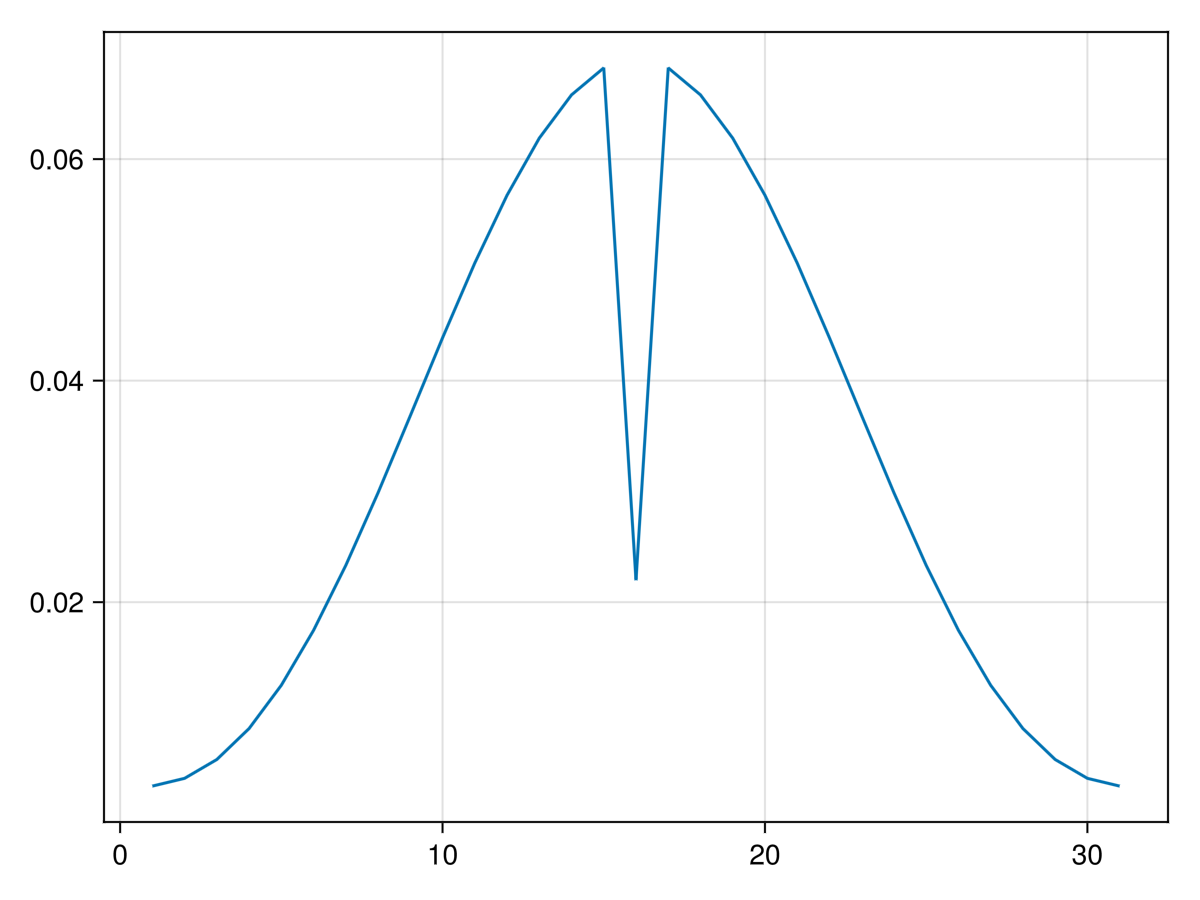

In [20]:
lines([0.0033950447, 0.0040946095, 0.0057959743, 0.008592194, 0.0125013925, 0.017460564, 0.023325475, 0.02987674, 0.036831845, 0.043862335, 0.050614957, 0.05673515, 0.061891224, 0.06579737, 0.06823364, 0.021982955, 0.06823364, 0.06579737, 0.06189122, 0.05673514, 0.050614953, 0.043862328, 0.036831837, 0.029876744, 0.023325471, 0.017460566, 0.012501388, 0.008592188, 0.005795971, 0.004094611, 0.0033950447]
)

In [19]:
firwin(31, 0.01724138)

31-element Vector{Float64}:
 0.02315392570102568
 0.02480777770583577
 0.026402846981516633
 0.02792841609912912
 0.029374159416594277
 0.03073022768895578
 0.03198732907569494
 0.03313680581489143
 0.03417070587161994
 0.03508184891217112
 0.03586388600607054
 0.03651135251396677
 0.03701971368074078
 ⋮
 0.03651135251396677
 0.03586388600607054
 0.03508184891217112
 0.03417070587161994
 0.03313680581489143
 0.03198732907569494
 0.03073022768895578
 0.029374159416594277
 0.02792841609912912
 0.026402846981516633
 0.02480777770583577
 0.02315392570102568

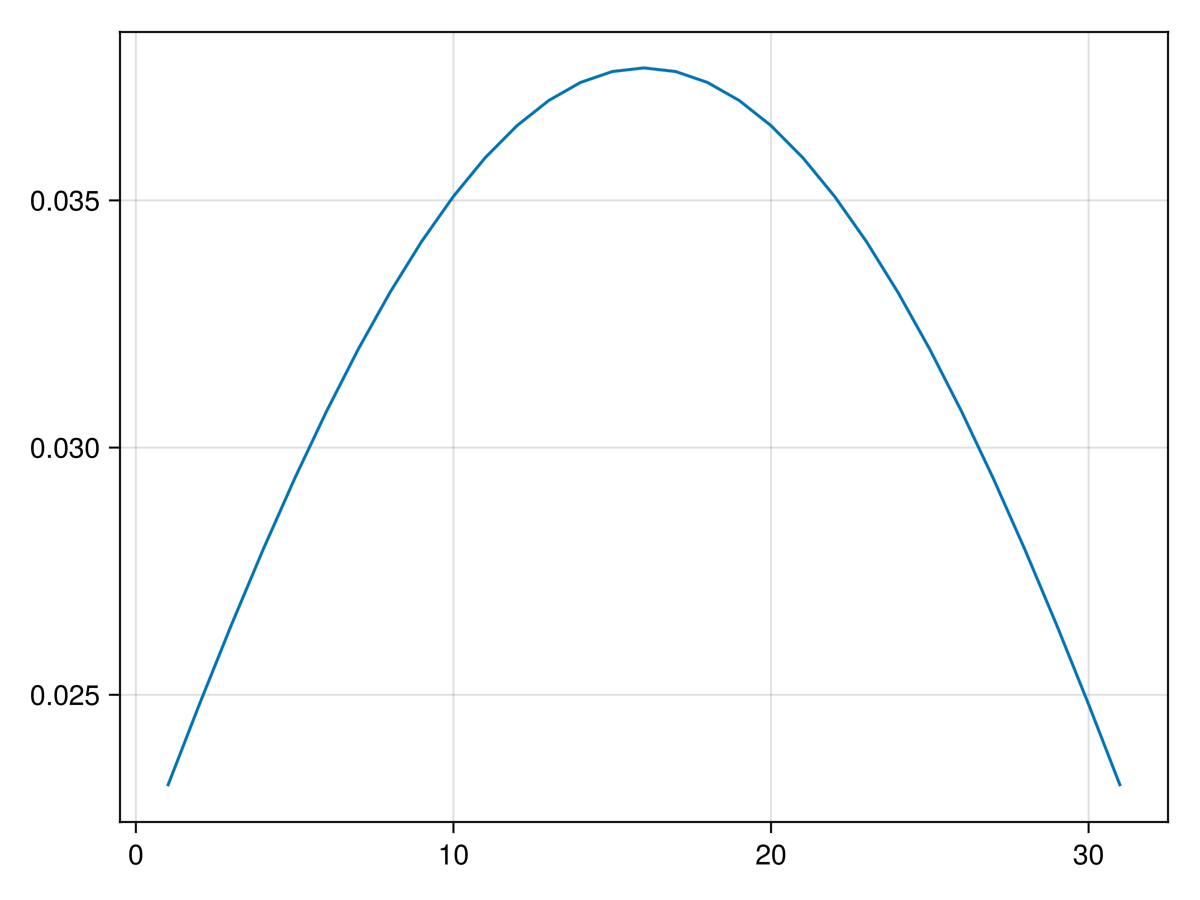

In [17]:
lines(firwin(31, 0.01724138))

In [4]:
function difference(x::AbstractArray, τ)
    d = zero(eltype(x))
    N = length(x)
    for j in 1:N-τ
        d += (x[j] - x[j+τ])^2
    end
    return d
end

difference (generic function with 1 method)

In [5]:
function first_local_minimum(x, min_threshold = 1.0)
    for i in 2:length(x)-1
        
        if x[i-1] > x[i] && x[i] < x[i+1]
            if x[i] < min_threshold
                return (i, x[i])
            end
        end
    end
    return nothing
end

first_local_minimum (generic function with 2 methods)

In [6]:
function decimate_fir(signal, fs, cutoff, downsample_factor)
    if cutoff >= fs / (2 * downsample_factor)
        error("Cutoff frequency must be less than the Nyquist frequency after downsampling (fs / (2 * downsample_factor)).")
    end
    if downsample_factor < 1
        error("Downsample factor must be an integer greater than or equal to 1.")
    end

    # Design FIR lowpass filter
    nyquist = fs / 2
    normalized_cutoff = cutoff / nyquist
    fir_filter = firwin(31, normalized_cutoff, window=hamming) # 101 taps, Hamming window

    # Apply FIR filter to the signal
    filtered_signal = filtfilt(fir_filter, signal) # Zero-phase filtering to prevent phase distortion

    # Downsample the signal
    downsampled_signal = filtered_signal[1:downsample_factor:end]

    return downsampled_signal
end

decimate_fir (generic function with 1 method)

In [7]:
function estimate_pitch(y, Fs, f_min = 30, f_max = 150, interpolate = true)
    volume = sum(abs.(y))/length(y)
    if volume < 0.01
        return nothing
    end
    range = floor(Int, Fs/f_max):ceil(Int, Fs/f_min)
    d = [difference(y, j) for j ∈ range]
    d′ = [j*d[j]/sum(d[1:j]) for j in 1:length(range)]

#     ind = findfirst(x -> x < 0.1, d′)

    τ = first_local_minimum(d′, 0.25)[1] - 1
    interpolation = (d′[τ - 1] - d′[τ + 1])/(2*(2*d′[τ] - d′[τ - 1] - d′[τ + 1]))

    τ += range[1] - 1
    
    if interpolate
        τ += interpolation
    end


    return Fs/τ

end

estimate_pitch (generic function with 4 methods)

In [8]:
function estimate_pitch_multiscale(y, fs, f_min, f_max)
    downsample_factor = floor(Int, fs/(5*f_max))
    y_filtered = decimate_fir(y, fs, fs/downsample_factor/2.01, downsample_factor)
    estimate = estimate_pitch(y_filtered, fs/downsample_factor, f_min, f_max, false)
    return estimate_pitch(y, fs, estimate-10, estimate+10)
end

estimate_pitch_multiscale (generic function with 1 method)

In [9]:
@time estimate_pitch(y, Fs)

  0.289550 seconds (172.85 k allocations: 18.486 MiB, 3.06% gc time, 29.41% compilation time)


55.99662568183943

In [11]:
@time estimate_pitch_multiscale(y, Fs, 30, 150)

  0.052495 seconds (315 allocations: 5.864 MiB)


55.99624004742257

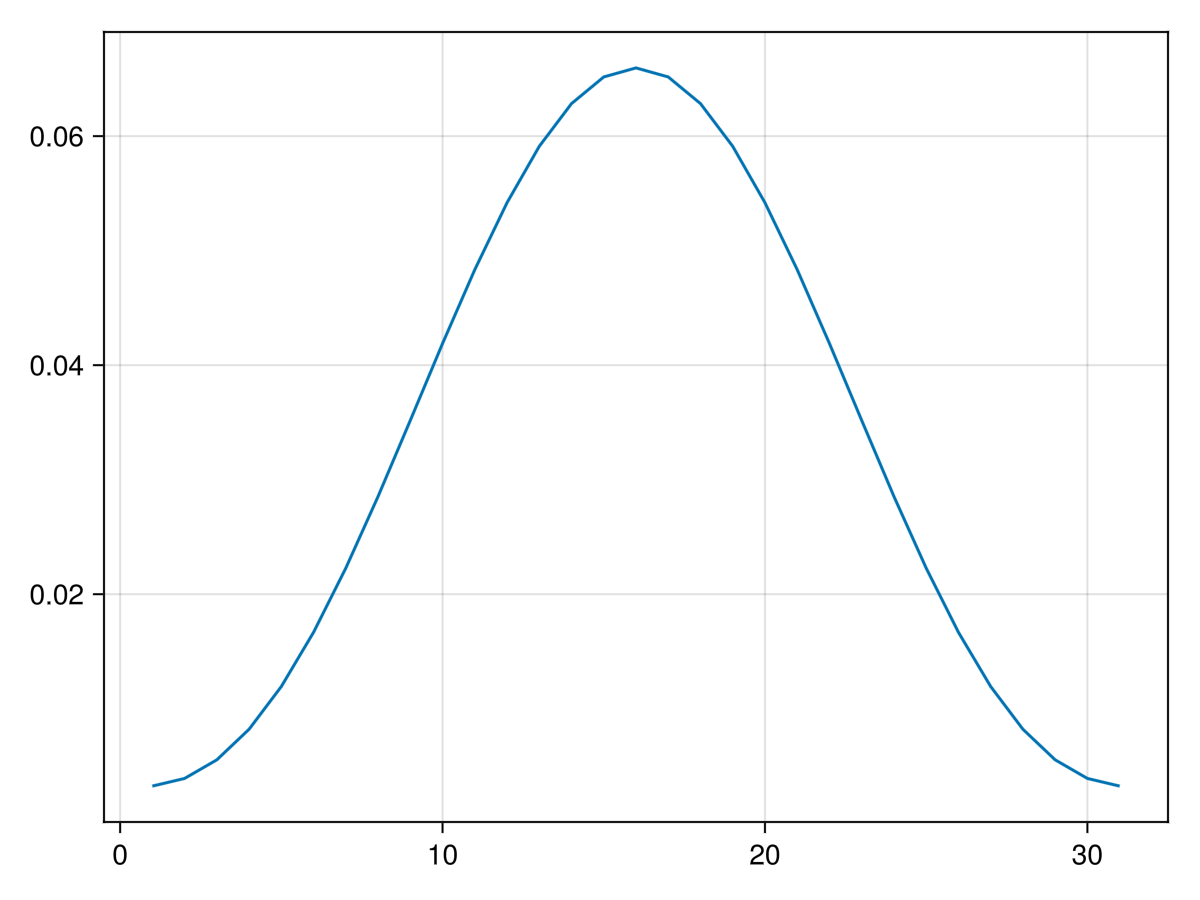

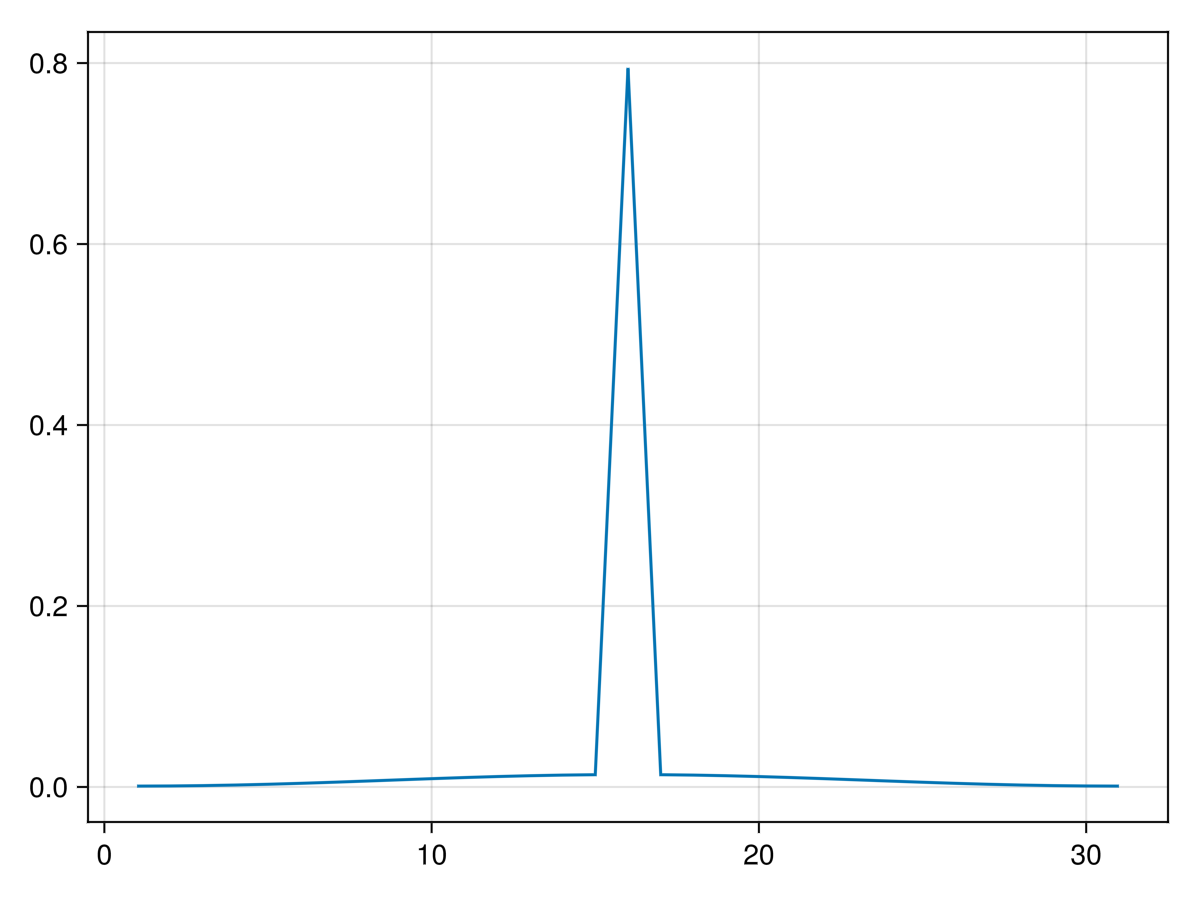

In [15]:
lines( [0.00097939, 0.00111889, 0.0015086483, 0.0021411602, 0.0029964019, 0.0040425807, 0.0052375356, 0.0065306937, 0.00786552, 0.009182295, 0.010421098, 0.011524849, 0.0124422, 0.013130183, 0.013556412, 0.79464436, 0.013556412, 0.013130183, 0.0124422, 0.011524846, 0.010421098, 0.009182292, 0.007865518, 0.0065306947, 0.005237534, 0.004042581, 0.002996401, 0.0021411588, 0.0015086473, 0.0011188905, 0.00097939]
)